In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import torch

from torch.autograd import grad
from matplotlib import rc
from torch.autograd.functional import jacobian

from scipy.signal import gaussian
from scipy.ndimage import filters

In [2]:
xs = np.linspace(-10,8, 200)
transition = lambda a : a + 1 if a < 4 else -4 * a + 21

In [3]:
def get_samples(n: int) -> float:
    start = np.random.uniform(-6, -4)
    samples_x = [start]
    samples_y = []
    for i in range(n):
        samples_y.append(np.random.normal(transition(samples_x[i]), 1))
        samples_x.append(samples_y[i])
    return samples_x[:-1], samples_y

Plotting

In [4]:
ys = [transition(a) for a in xs]
samples_x, samples_y = get_samples(15)

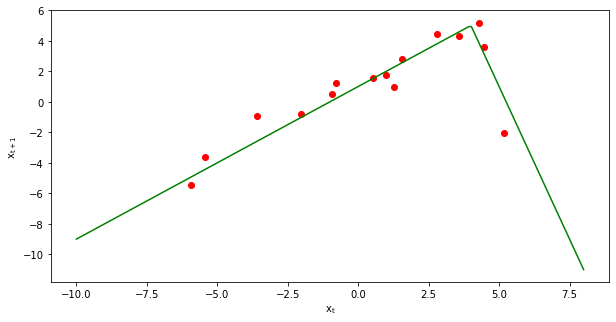

In [5]:
plt.figure(figsize=(10,5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel('$x_{t}$')
plt.ylabel('$x_{t + 1}$')
plt.plot(xs, ys, color='green')
plt.scatter(samples_x, samples_y, color='red')
plt.show()

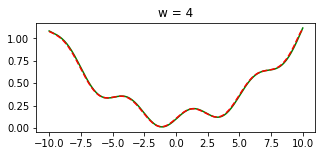

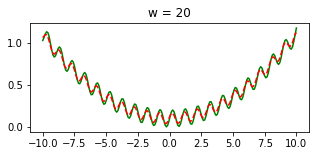

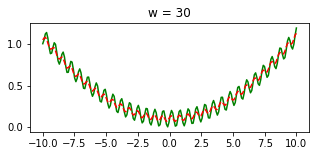

In [42]:
bs = np.linspace(-10, 10, 200)

for w in [4,20,30]:
    f = lambda b: 0.1 * np.sin(b * w / np.pi) + (b/10)**2 + 0.1

    cs = [f(b) for b in bs]
    g = gaussian(200, 1.5)
    smoothed = filters.convolve1d(cs, g/g.sum())

    plt.figure(figsize=(5,2))
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)

    plt.plot(bs, cs, color='green')
    plt.plot(bs, smoothed, color='red', linestyle='dashed')
    plt.title(f"w = {w}")
    plt.show()

***Sandbox***

In [22]:
with torch.no_grad():
    s = [torch.tensor([1.,2.,3.], requires_grad=True) for _ in range(3)]
    sample_points = torch.cat(s).view(3, -1)
sample_points.requires_grad=True

mu = torch.FloatTensor([2,3])
mu.requires_grad=True
sigma = torch.FloatTensor([2.0000001,4.0000000001])
norm = torch.distributions.normal.Normal(mu, sigma)

k = norm.sample()

k.requires_grad = True

f = norm.log_prob(k)

f.backward(gradient=torch.ones(2))

print(np.linspace(0.05, 9.5, 50))


[0.05       0.24285714 0.43571429 0.62857143 0.82142857 1.01428571
 1.20714286 1.4        1.59285714 1.78571429 1.97857143 2.17142857
 2.36428571 2.55714286 2.75       2.94285714 3.13571429 3.32857143
 3.52142857 3.71428571 3.90714286 4.1        4.29285714 4.48571429
 4.67857143 4.87142857 5.06428571 5.25714286 5.45       5.64285714
 5.83571429 6.02857143 6.22142857 6.41428571 6.60714286 6.8
 6.99285714 7.18571429 7.37857143 7.57142857 7.76428571 7.95714286
 8.15       8.34285714 8.53571429 8.72857143 8.92142857 9.11428571
 9.30714286 9.5       ]


***Toy Problem Experiments***

In [54]:
def get_rp_gradient_variance(N: int, variance: float, range_start: int, range_end: int, input_points, w: float):
    with torch.no_grad():
        mean_matrix = torch.cat(
            [torch.full((1,N), float(x)) for x in np.linspace(range_start, range_end, input_points)]
#             [torch.full((1,N), float(x)) for x in range(range_start, range_end)]

        )
        mean_matrix.requires_grad=True
        var_matrix = torch.eye(N) * variance
        var_matrix.requires_grad=True
    
    # Standard Normal Samples
    samples = torch.cat(
        [torch.normal(0., 1., size=(1,N)) for x in np.linspace(range_start, range_end, input_points)]
#             [torch.normal(0., 1., size=(1,N)) for x in range(range_start, range_end)]
    )
    
    # Reparameterization gradient - function application
    g = samples @ var_matrix + mean_matrix
    f = 0.1 * torch.sin(g * w / torch.pi) + (g/10)**2 + 0.1    
    
    # Reparemeterized gradients - gradient computation
    f.backward(gradient=torch.ones(mean_matrix.shape))

    mu_grad = torch.var(mean_matrix.grad, dim=1, keepdim=True)
    var_grad = torch.var(var_matrix.grad, dim=1, keepdim=True)
    
    return torch.max(mu_grad), torch.max(var_grad)

In [55]:
def get_lr_gradient_variance(N: int, variance: float, range_start: int, range_end: int, input_points, w: float):
    # Likelihood ratio - log probabilities    
#     mean_matrix = torch.cat([torch.full((1,N), float(x)) for x in range(-10, 10)])
    mean_matrix = torch.cat([torch.full((1,N), float(x)) for x in np.linspace(range_start, range_end, input_points)])
    mean_matrix.requires_grad = True  
    variance_matrix = torch.full((input_points,N), variance, requires_grad=True, dtype=torch.float32)
            
    normal = torch.distributions.normal.Normal(mean_matrix, variance_matrix)
    
    samples = normal.sample()

    log_probs = normal.log_prob(samples)
    
    
    # Likelihood ratio - function application
    f = 0.1 * torch.sin(samples * w / torch.pi) + (samples/10)**2 + 0.1
    loss = log_probs.t() @ f
    
    loss.backward(gradient=torch.ones((N,N)))
        
    mu_grad = torch.var(mean_matrix.grad, dim=1, keepdim=True)
    var_grad = torch.var(variance_matrix.grad, dim=1, keepdim=True)

    return torch.max(mu_grad), torch.max(var_grad)

In [69]:
# Constants
N = 1000 # Number of samples per input value
input_points = 100 # Number of points to take from our range (-10, 10)

# Distribution parameters
variance = 10.

range_start = -10
range_end = 10
    
oscillations = np.linspace(10e-3, 10e4, 500)

rp_var_grad_vars = torch.zeros(oscillations.shape)
rp_mu_grad_vars = torch.zeros(oscillations.shape)

lr_var_grad_vars = torch.zeros(oscillations.shape)
lr_mu_grad_vars = torch.zeros(oscillations.shape)

for i, w in enumerate(oscillations):
    # Reparameterized gradients
    rp_mu_grad, rp_var_grad = get_rp_gradient_variance(
                                    N=N,
                                    variance=variance,
                                    range_start=-10,
                                    range_end=10,
                                    input_points=input_points,
                                    w=w
                                )
    
    rp_mu_grad_vars[i] = rp_mu_grad
    rp_var_grad_vars[i] = rp_var_grad

    
    # Likelihood ratio gradients
    lr_mu_grad, lr_var_grad = get_lr_gradient_variance(
                                    N=N,
                                    variance=variance,
                                    range_start=-10,
                                    range_end=10,
                                    input_points=input_points,
                                    w=w
                                )
    
    lr_mu_grad_vars[i] = lr_mu_grad
    lr_var_grad_vars[i] = lr_var_grad

***Gradient Variance Plots***

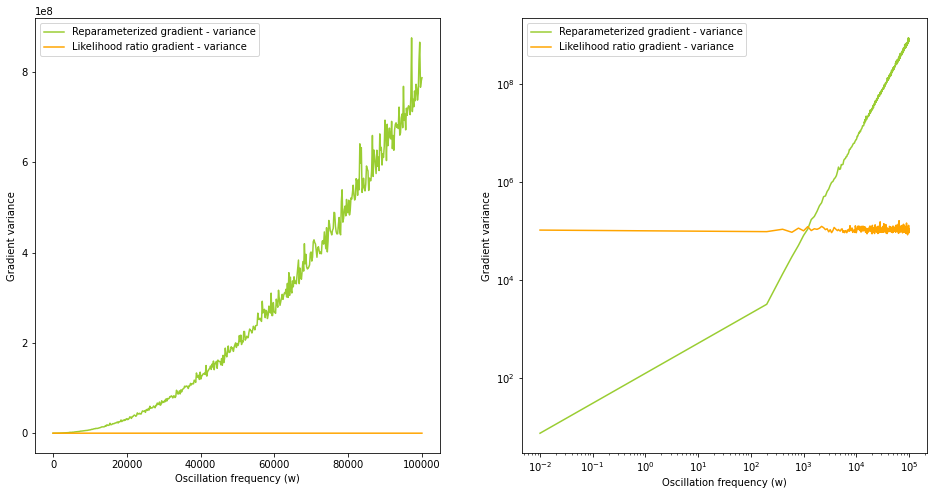

In [70]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1, 2)

# ax[0].plot(oscillations, rp_mu_grad_vars, color='cornflowerblue', label="Reparameterized gradient - mean")
ax[0].plot(oscillations, rp_var_grad_vars, color='yellowgreen', label="Reparameterized gradient - variance")
ax[0].plot(oscillations, lr_var_grad_vars, color='orange', label="Likelihood ratio gradient - variance")
# ax[0].plot(oscillations, lr_mu_grad_vars, color='palegreen', label="Likelihood ratio gradient - mean")
ax[0].set_xlabel("Oscillation frequency (w)")
ax[0].set_ylabel("Gradient variance")
ax[0].legend()

# ax[1].plot(oscillations, rp_mu_grad_vars, color='cornflowerblue', label="Reparameterized gradient - mean")
ax[1].plot(oscillations, rp_var_grad_vars, color='yellowgreen', label="Reparameterized gradient - variance")
ax[1].plot(oscillations, lr_var_grad_vars, color='orange', label="Likelihood ratio gradient - variance")
# ax[1].plot(oscillations, lr_mu_grad_vars, color='palegreen', label="Likelihood ratio gradient - mean")
ax[1].set_xlabel("Oscillation frequency (w)")
ax[1].set_ylabel("Gradient variance")
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend()


plt.show()

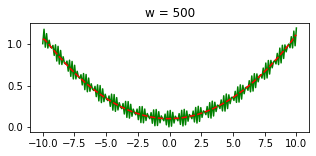

In [130]:
# Data points
xs = np.linspace(-10, 10, 200)
foo = lambda x: 0.1 * np.sin(x * w / np.pi) + (x / 10)**2 + 0.1
ys = [foo(x) for x in xs]

# Distributions
gauss = gaussian(200, sample_var)
smoothed = filters.convolve1d(ys, gauss/gauss.sum())

# Plots
plt.figure(figsize=(5,2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.plot(xs, ys, color='green')
plt.plot(xs, smoothed, color='red', linestyle='dashed')
plt.title(f"w = {w}")
plt.show()